Goal: EDA of the 
1. randomly generated circuits, with stats on n_ops and n_qubits
1. plot some execution results as distributions (focus on small number of qubits)
1. plot the execution results of many number of qubits focusing on the most popular bitstrings
1. check how many unique bitstrings are needed to reach 20% of the distribution
1. plot the similarity between output strings (bitflip distance (aka XOR) or edit distance)
1. plot the scatterplot: n qubits vs ks_test pvalue
1. etc...

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import yaml

In [3]:
CONFIG_FILE = "../config/experiment_00.yaml"
with open(CONFIG_FILE, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Data Reading

In [31]:
def get_df(file_list, folder, 
           provenance_column=None, 
           keyword_to_check="", string_to_remove="", 
           unpack_json=True):
    """Read all the json file in a dataframe."""
    all_data = []
    for filename in file_list:
        with open(os.path.join(folder, filename), "r") as f:
            json_content = json.load(f)
            if unpack_json:
                data = json_content
            else: 
                data = dict()
                data["json_content"] = json_content
        if keyword_to_check in filename:
            filename = filename.replace(string_to_remove, "")
        data['filename'] = filename
        all_data.append(data)
    df = pd.DataFrame.from_records(all_data)
    if not provenance_column is None:
        df['test_name'] = provenance_column
    return df

In [ ]:
def load_executions

In [21]:
all_files = os.listdir(config["folder_comparison_results"])

energy_files = [
    f 
    for f in all_files
    if f.endswith(".json") and "energy" in f 
]

ks_files = [
    f for f in all_files
    if f.endswith(".json") and not "energy" in f 
]

In [33]:
df_energy = get_df(
    file_list=energy_files, 
   folder=config["folder_comparison_results"],
   keyword_to_check="energy", 
   string_to_remove="_energy",
   provenance_column="energy")
df_ks = get_df(
    file_list=ks_files,
    folder=config["folder_comparison_results"],
    provenance_column="ks")
df_ks.head(2)

,statistic,p_value,filename,test_name
0,0.012573,0.536562,1638906632_4069.json,ks
1,0.587646,0.000000,1638906629_0918.json,ks


In [26]:
# load all the data from the circuit characteristics
circuit_files = [
    f for f in os.listdir(config["folder_generated_qasm"])
    if f.endswith(".json")
]
df_circuit = get_df(
    file_list=circuit_files, 
    folder=config["folder_generated_qasm"])
df_circuit.head(2)

,n_qubits,n_ops,gate_set,strategy_program_generation,filename
0,4,98,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,1638906632_4069.json
1,17,71,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,1638906629_0918.json


In [36]:
# load all the execution data
dfs = []
for platform_name in ["QiskitCircuit", "CirqCircuit"]:
    execution_result_files = [
        f for f in os.listdir(config["folder_execution_results"])
        if f.endswith(".json") and platform_name in f
    ]
    df_platform = get_df(
        file_list=execution_result_files, 
        folder=config["folder_execution_results"],
        keyword_to_check=platform_name, 
        string_to_remove="_" + platform_name,
        unpack_json=False
    )
    df_platform.rename(columns={"json_content": platform_name}, inplace=True)
    dfs.append(df_platform)
df_excutions = pd.merge(dfs[0], dfs[1], on="filename")
df_excutions.head(2)

,QiskitCircuit,filename,CirqCircuit
0,"{'111001110000': 1, '100110000011': 1, '011010...",1638906629_9244.json,"{'111000100011': 14, '101101001010': 1, '10101..."
1,"{'01001000111': 1, '00001110110': 1, '00111101...",1638906633_4850.json,"{'01011100101': 4, '11001010001': 20, '1100010..."


In [37]:
# merge all 
df_all = pd.merge(df_ks, df_circuit, on="filename") 
df_all = pd.merge(df_all, df_excutions, on="filename")
df_all.head(2)

,statistic,p_value,filename,test_name,n_qubits,n_ops,gate_set,strategy_program_generation,QiskitCircuit,CirqCircuit
0,0.012573,0.536562,1638906632_4069.json,ks,4,98,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,"{'1001': 20, '1000': 293, '1011': 171, '1010':...","{'0101': 920, '0000': 1050, '1111': 543, '0100..."
1,0.587646,0.000000,1638906629_0918.json,ks,17,71,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,"{'00110000111101011': 1, '00001101111001001': ...","{'11111010111111000': 144, '11110011001000011'..."


# Derived Features

In [107]:
# (%) uniform threshold
# (%) cumulative percentage of top k (k = 1, 5, 10, 100, ...)
# (unit) ratio uniform units: cum_top_k / uniform
def cumulative_perc_top_k(occurrences, top_k=[1,5,10,100,1000]):
    """Get the percentage of occurences of the top k solutions."""
    total = sum(occurrences)
    sorted_occurences = sorted(occurrences, reverse=True)
    sorted_perc = [o / total for o in sorted_occurences]
    cum_perc = [
        sum(sorted_perc[:k]) 
        for k in top_k
    ]
    return cum_perc
    
        

In [112]:
top_k_values = [1, 5, 10, 100, 1000]

df_all["cum_perc"] = df_all.apply(
    lambda row: cumulative_perc_top_k(row["QiskitCircuit"].values(), top_k=top_k_values), 
    axis=1
)
for i, k in enumerate(top_k_values):
    df_all[f"cum_perc_{k}"] = df_all["cum_perc"].apply(lambda x: x[i])
    df_all["unif_perc"] = df_all["n_qubits"].apply(lambda n_bits: 1 / (2**n_bits))
    df_all[f"uniform_unit_top_{k}"] = df_all.apply(
        lambda row: row["cum_perc"][i] / row["unif_perc"], 
        axis=1
    )
df_all.head(3)

,statistic,p_value,filename,test_name,n_qubits,n_ops,gate_set,strategy_program_generation,QiskitCircuit,CirqCircuit,...,cum_perc_5,cum_perc_10,cum_perc_100,cum_perc_1000,uniform_unit_top_1,uniform_unit_top_5,uniform_unit_top_10,uniform_unit_top_100,uniform_unit_top_1000,unif_perc
0,0.012573,5.365621e-01,1638906632_4069.json,ks,4,98,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,"{'1001': 20, '1000': 293, '1011': 171, '1010':...","{'0101': 920, '0000': 1050, '1111': 543, '0100...",...,0.603027,0.883057,1.000000,1.000000,2.402344,9.648438,14.128906,16.0,16.0,0.062500
1,0.587646,0.000000e+00,1638906629_0918.json,ks,17,71,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,"{'00110000111101011': 1, '00001101111001001': ...","{'11111010111111000': 144, '11110011001000011'...",...,0.086426,0.158936,0.665405,0.998901,2336.000000,11328.000000,20832.000000,87216.0,130928.0,0.000008
2,0.269409,7.478938e-262,1638906637_2420.json,ks,19,52,"{'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}",weighted,"{'0000100000010001001': 1, '100100101001010001...","{'1000100111100100000': 4, '001000010000000000...",...,0.150879,0.265503,0.814087,1.000000,19008.000000,79104.000000,139200.000000,426816.0,524288.0,0.000002


# EDA

## Generated Circuits (N_ops and N_qubits)

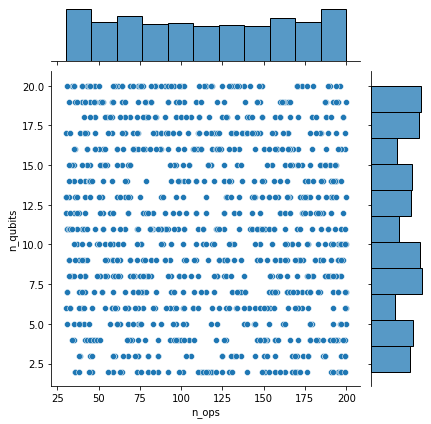

In [30]:
# randomly generated circuits, with stats on n_ops and n_qubits
sns.jointplot(
    data=df_all, 
    x="n_ops",
    y="n_qubits"
)

## Execution Results (raw bitstrings occurrence)

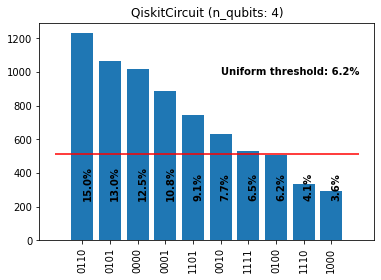

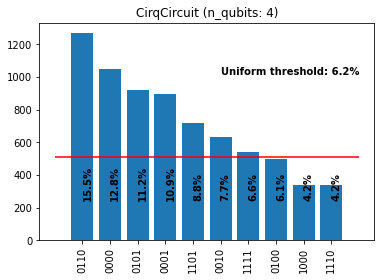

In [114]:
# plot some execution results as distributions (focus on small number of qubits)


def plot_execution_result(df, circuit_name, platforms=["QiskitCircuit"], top_k=10):
    """Plot the histograms of the circuit execution on the platforms."""
    record = df[df["filename"] == circuit_name.strip()].iloc[0]
    for platform in platforms: 
        execution_dict = record[platform]
        pairs_solution_frequency = list(execution_dict.items())
        occurences = [e[1] for e in pairs_solution_frequency]
        total = sum(occurences)
        max_value = max(occurences)
        n_qubits = len(pairs_solution_frequency[0][0])
        expected_uniform_occurency = (float(1)/2**n_qubits) * 100
        if len(pairs_solution_frequency) > top_k:
            pairs_solution_frequency = sorted(pairs_solution_frequency, key= lambda x: x[1], reverse=True)[:top_k]
        else: 
            pairs_solution_frequency = sorted(pairs_solution_frequency)       
        strings, occurrences = list(zip(*pairs_solution_frequency))
        plt.bar(x=range(len(strings)), height=occurrences, tick_label=strings)
        plt.xticks(rotation=90)
        plt.title(f"{platform} (n_qubits: {n_qubits})")
        for i, (k, v) in enumerate(pairs_solution_frequency):
            perc = ((float(v) / total) * 100)
            plt.text(i, max_value / 5, f"{perc:.1f}%", color='black', fontweight='bold', rotation=90)
        plt.text(int(top_k/2), max_value * .8, 
                 f"Uniform threshold: {expected_uniform_occurency:.1f}%", 
                 color='black', fontweight='bold')
        plt.hlines(expected_uniform_occurency * total / 100, -1, top_k, colors='red')
        
        plt.show()
    return 
    
plot_execution_result(df=df_all, circuit_name="1638906632_4069.json", platforms=["QiskitCircuit", "CirqCircuit"], top_k=10)

1638906633_5576.json


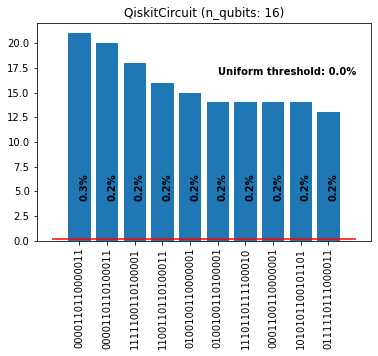

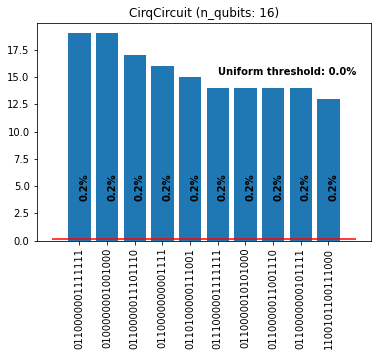

1638906632_3699.json


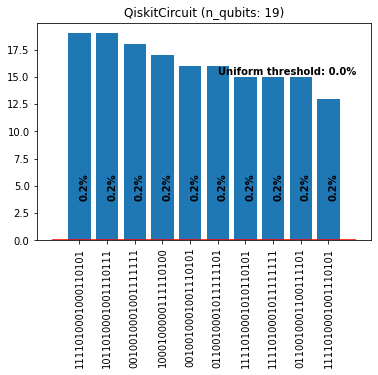

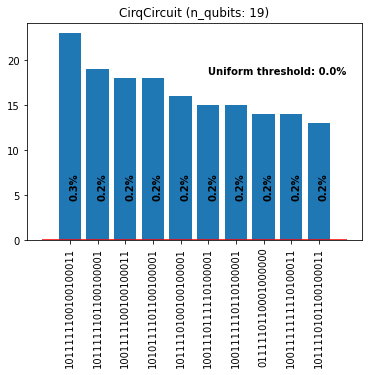

1638906637_8171.json


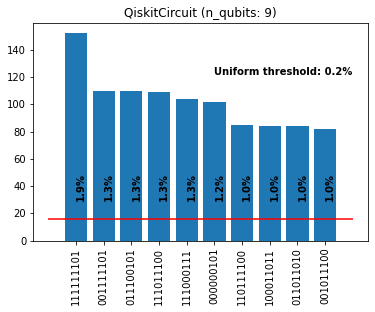

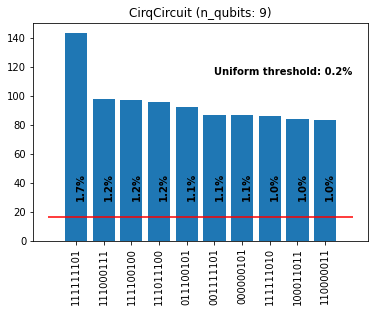

1638906635_2307.json


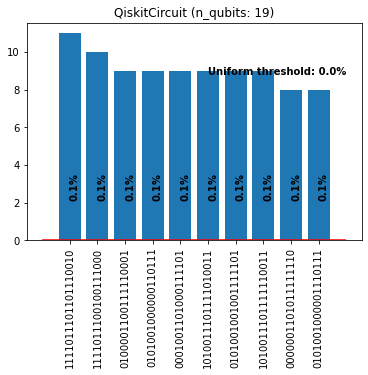

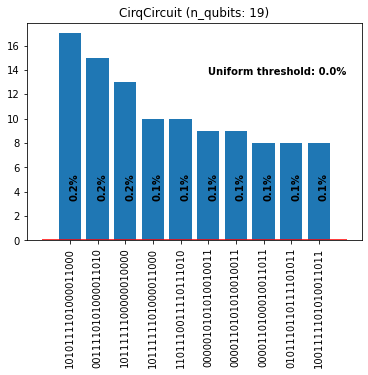

1638906632_6713.json


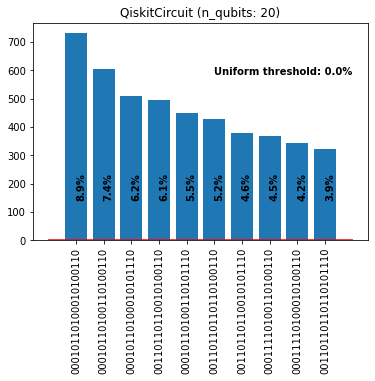

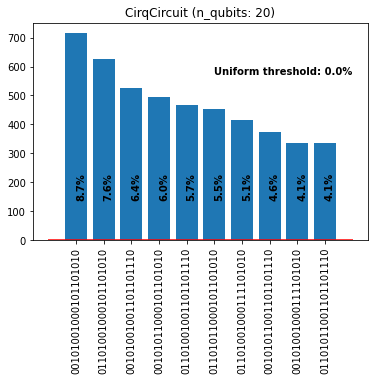

1638906630_8188.json


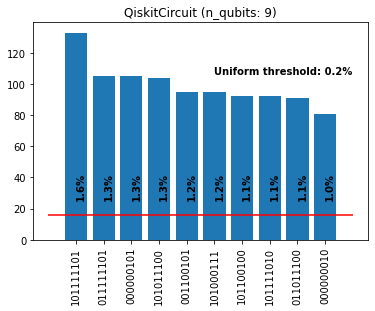

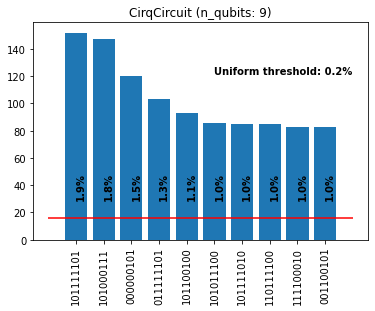

1638906635_7264.json


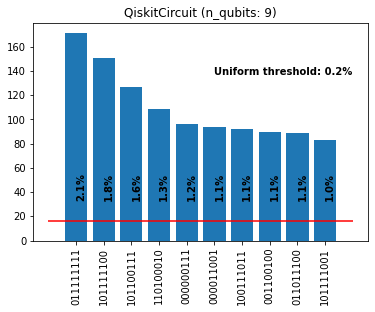

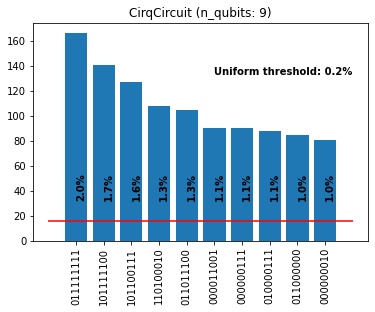

1638906637_0365.json


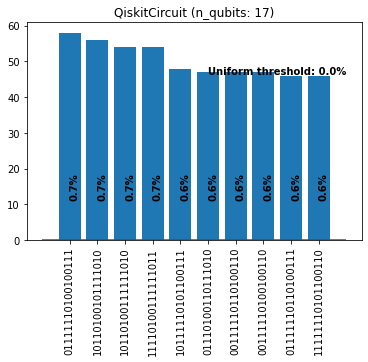

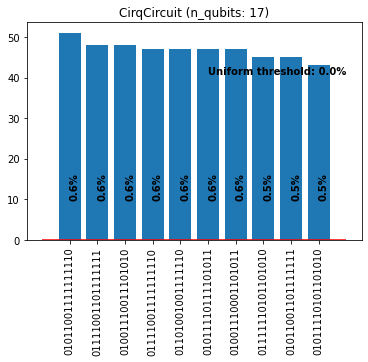

1638906629_9244.json


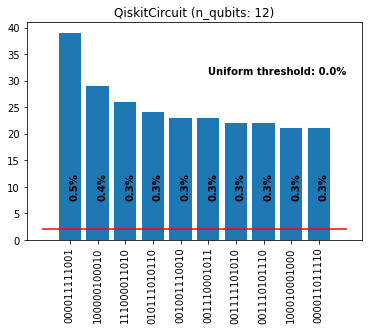

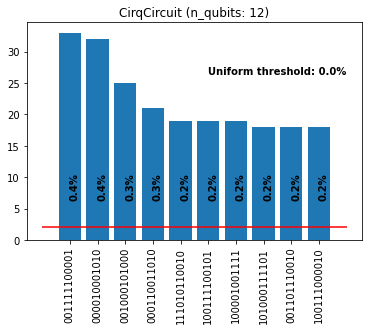

1638906634_1938.json


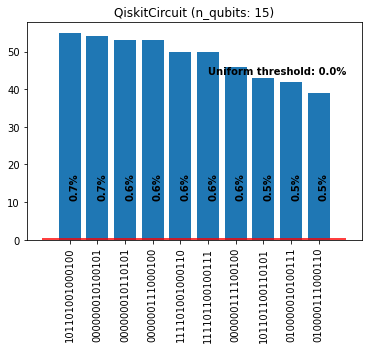

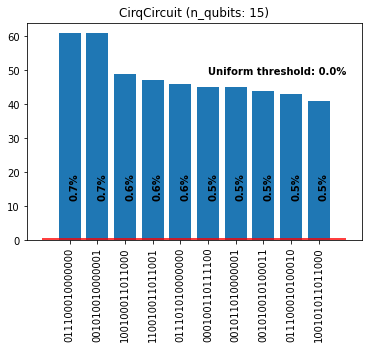

In [136]:
# plot the execution results of many number of qubits focusing on the most popular bitstrings

names = df_all['filename'].sample(n=10, random_state=42)
for name in names:
    print(name)
    plot_execution_result(df=df_all, circuit_name=name, platforms=["QiskitCircuit", "CirqCircuit"], top_k=10)

## Explore Real Circuit Configuration

In [ ]:
import sys
sys.path.append("../lib")
from simulators import *

In [123]:
def plot_circuit(circuit_name, platform, execution_folder):
    """Given the circuit name (no file extension) it prints the schematic."""
    with open(os.path.join(execution_folder, circuit_name + ".qasm"), "r") as f:
        qasm_content = f.read()
    simulator_object = eval(platform)(repetitions=0)
    simulator_object.from_qasm(qasm_content)
    simulator_object.draw()
    return
    
plot_circuit(circuit_name="1638906632_6713", 
             platform="QiskitCircuit", 
             execution_folder=config["folder_generated_qasm"])

       ┌────────────┐                                                 »
 q_0: ─┤ Ry(6.0941) ├─────────────────────────────────────────────────»
       └────────────┘                                                 »
 q_1: ──────────────────────────────────────■─────────────────────────»
       ┌────────────┐                       │                         »
 q_2: ─┤ Rx(3.1113) ├───────────────────────┼─────────────────────────»
      ┌┴────────────┤┌─────────────┐        │          ┌────────────┐ »
 q_3: ┤ Ry(0.98014) ├┤ Ry(0.40873) ├────────┼──────────┤ Rx(6.0921) ├─»
      └┬────────────┤└─────────────┘        │          └────────────┘ »
 q_4: ─┤ Rz(1.1424) ├───────────────────────┼─────────────────────────»
       ├────────────┤                       │                         »
 q_5: ─┤ Rx(3.8444) ├───────────────────────┼────────────────■────────»
       └────────────┘                       │                │        »
 q_6: ──────────────────────■───────────────┼────────────────┼──

## Explore Derived Features

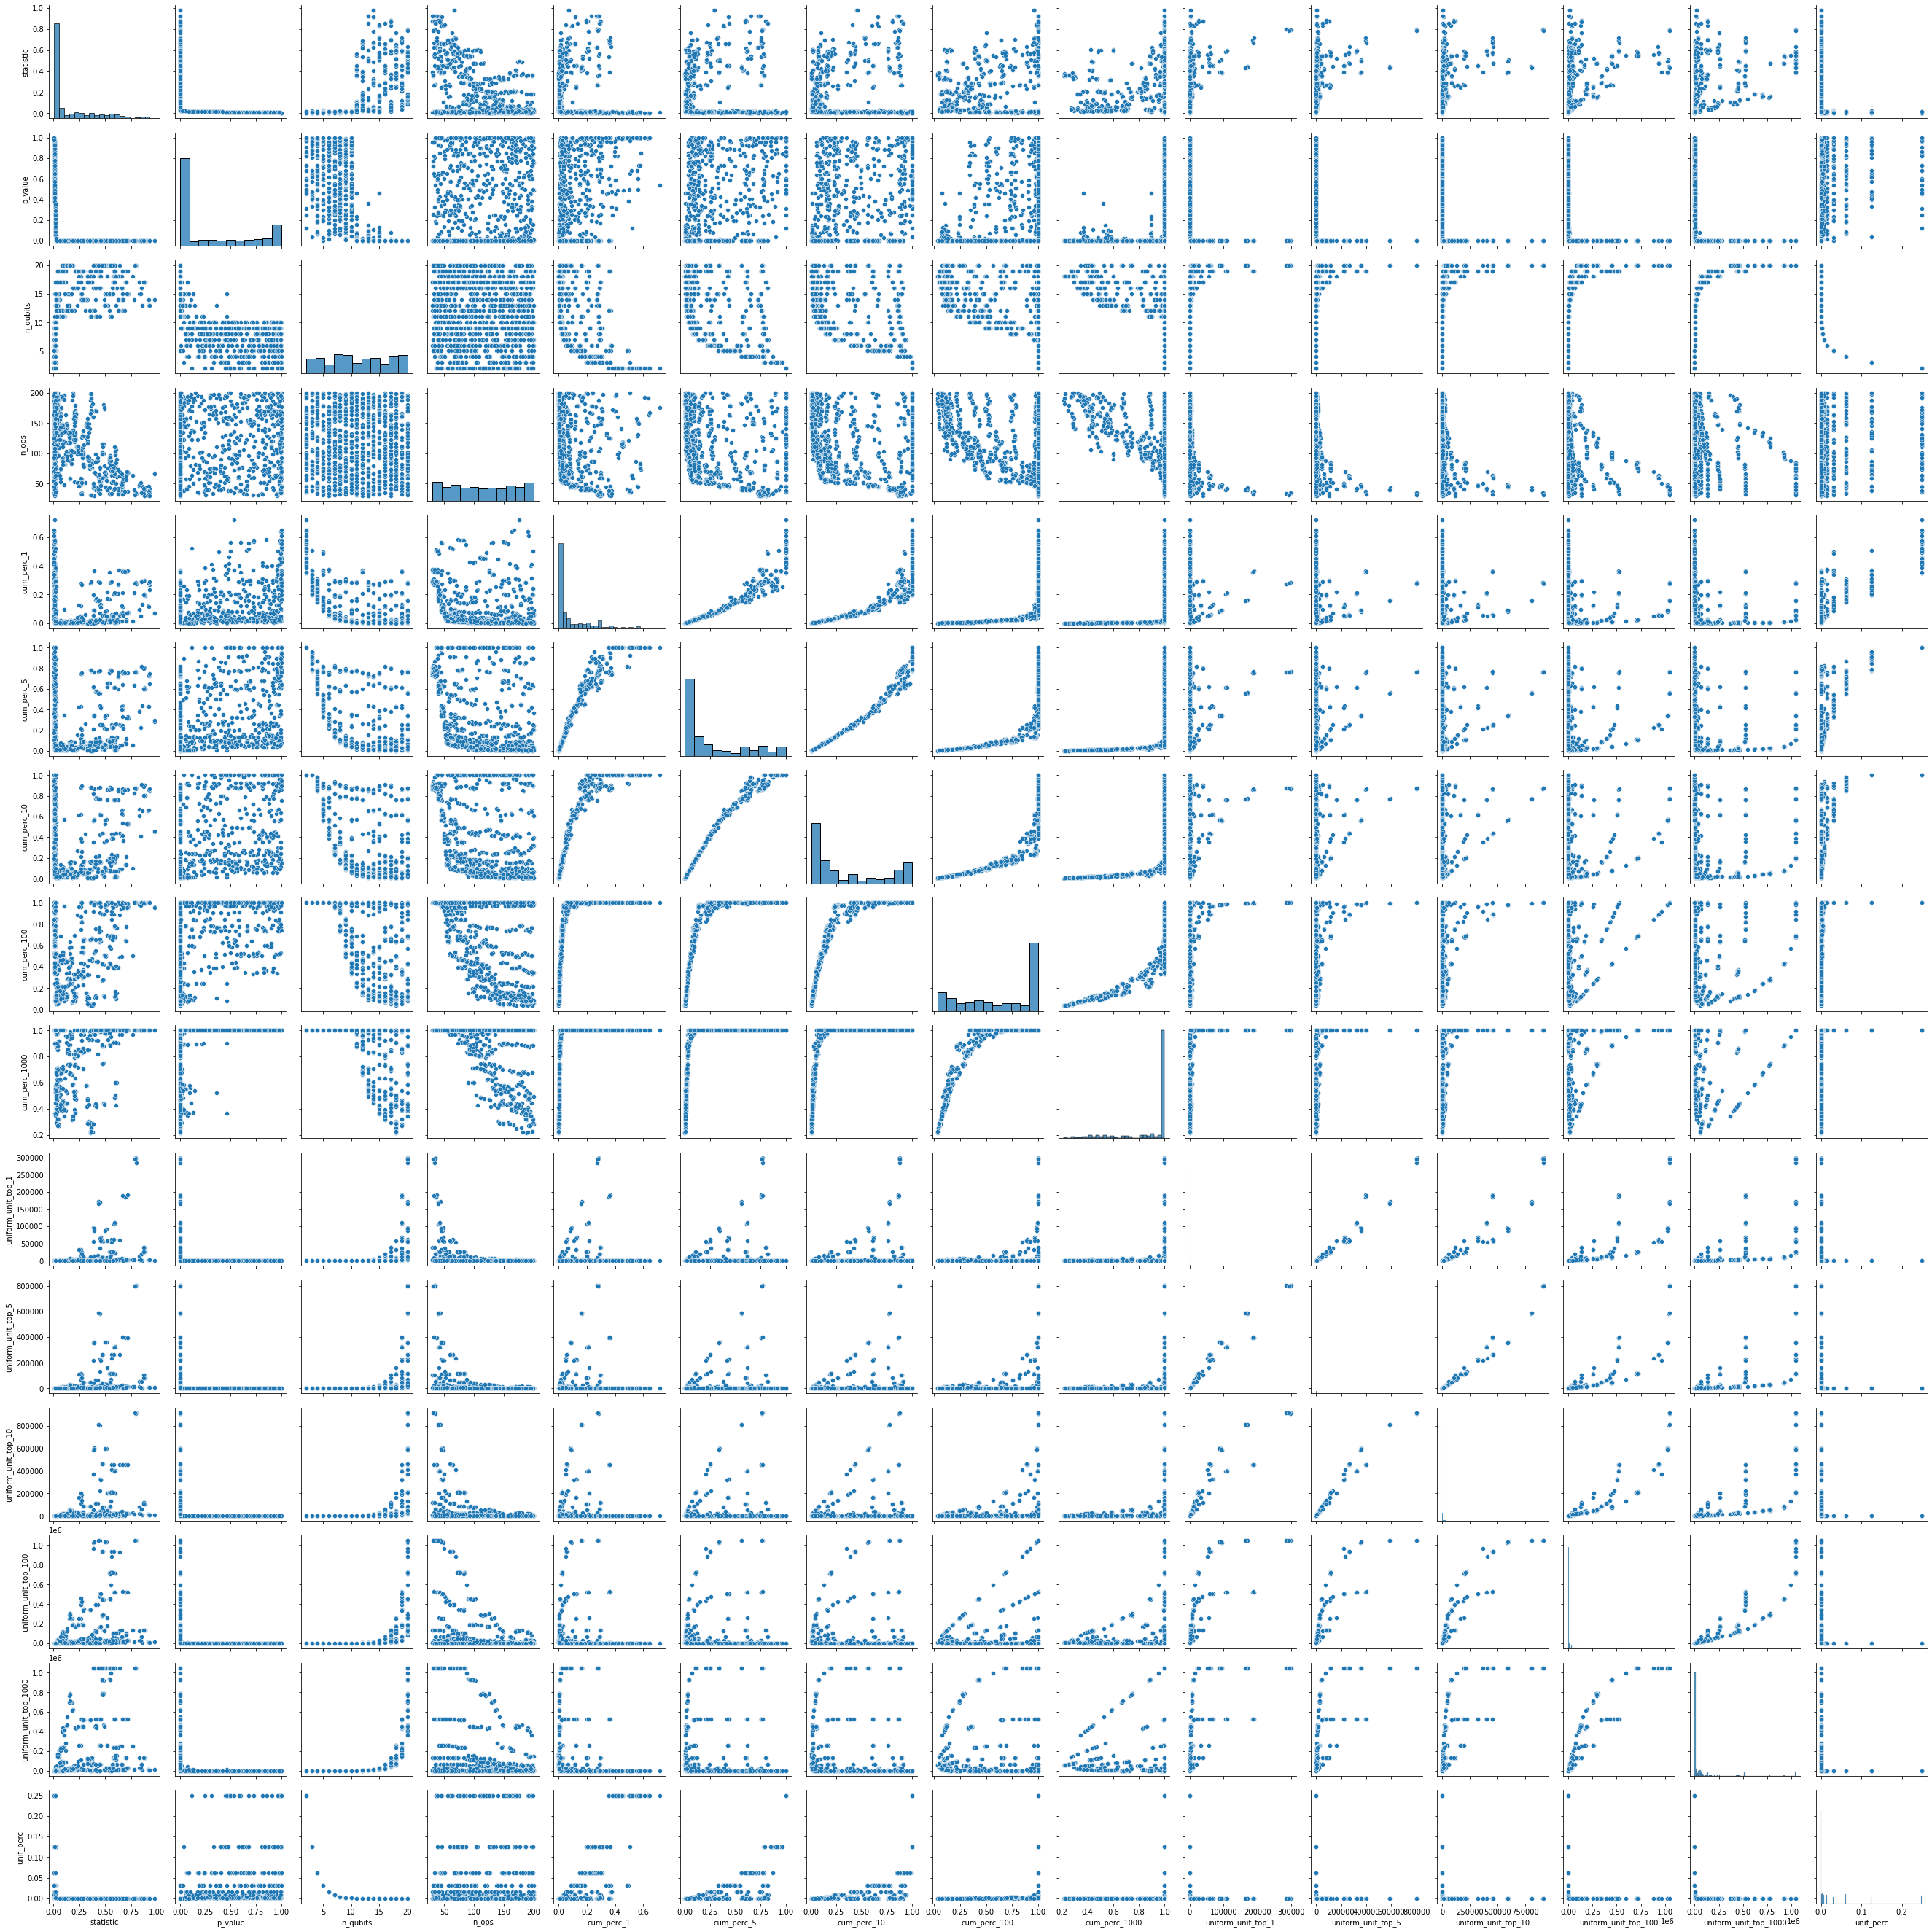

In [113]:
sns.pairplot(
    data=df_all
)

## Sensitivity KS-Test (no. qubits and no. ops)

Is the KS-test more prone to raise an alert of divergent computation with programs with more qubits?


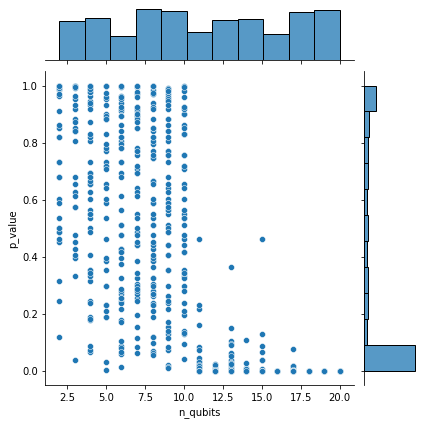

In [132]:
# plot the scatterplot: n qubits vs ks_test pvalue
print('Is the KS-test more prone to raise an alert of divergent computation with programs with more qubits?')
sns.jointplot(
    data=df_all, 
    y="p_value",
    x="n_qubits"
)

Is the KS-test more prone to raise an alert of divergent computation with programs with more operations?


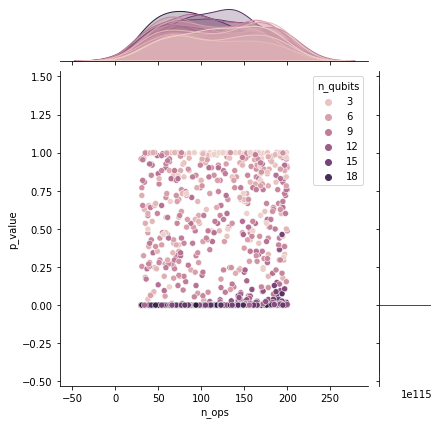

In [133]:
# plot the scatterplot: n ops vs ks_test pvalue
print('Is the KS-test more prone to raise an alert of divergent computation with programs with more operations?')
sns.jointplot(
    data=df_all, 
    y="p_value",
    x="n_ops",
    hue="n_qubits"
)

# Heatmap of Bitflip difference (Cirq vs Qiskit)

In [140]:
def bitflip_distance(a, b):
    y = int(a, 2)^int(b,2)
    xor_string = bin(y)[2:].zfill(len(a))
    #print(xor_string)
    return xor_string.count('1')

In [157]:
import nltk
import numpy as np
import math
from tqdm import tqdm


def inspect(code, p_value, folder, top_k=10, ax=None, verbose=False):
    """Plot the agreement on the most frequent values."""
    platforms = ["QiskitCircuit", "CirqCircuit"]

    records = []

    for platform in platforms:
        with open(os.path.join(folder, code + "_" + platform + ".json"), 'r') as f:
            results = json.load(f)
        if verbose:
            print("-" * 80)
            print(platform)
        ordered = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
        for i, (k, v) in enumerate(ordered.items()):
            if i >= top_k:
                break
            if verbose:
                print(k, v)
            record = dict()
            record["value"] = k
            record["shots"] = v
            record["platform"] = platform
            records.append(record)

    list_A = [r for r in records if r["platform"] == "QiskitCircuit"]
    list_B = [r for r in records if r["platform"] == "CirqCircuit"]

    size = len(list_A)
    m = np.zeros((size, size))
    for i, a in enumerate(list_A):
        for j, b in enumerate(list_B):
            
            m[i][j] = bitflip_distance(a["value"], b["value"])
            #m[i][j] = nltk.edit_distance(a["value"], b["value"])

    n_bits = len(records[0]["value"])
    
    cmap_color = "Reds"
    #if ax == None:
    #    sns.heatmap(m, annot=True, cmap=cmap_color, vmin=0, vmax=n_bits)
    #else:
    sns.heatmap(m, annot=True, cmap=cmap_color, vmin=0, vmax=n_bits, 
                yticklabels=[a["value"] for a in list_A], 
                xticklabels=[b["value"] for b in list_B], 
                ax=ax)
    ax.set_xlabel("CirqCircuit")
    ax.set_ylabel("QiskitCircuit")
    
    ax.set_title(f"{str(n_bits)} bits (pval={p_value})")

0it [00:00, ?it/s]

--------------------------------------------------------------------------------
QiskitCircuit
00010110100010100110 731
00010110100110100110 606
00010110100010101110 509
00110110110010100110 496
00010110100110101110 449
00110110110110100110 429
00110110110010101110 378
00011110100110100110 367
00011110100010100110 342
00110110110110101110 321
00011110100110101110 263
00111110110110100110 260
00111110110010100110 255
00011110100010101110 228
00111110110010101110 195
00111110110110101110 187
01000100000101000100 94
01000100000001000100 81
01000100000001001100 80
01100100010101000100 70
--------------------------------------------------------------------------------
CirqCircuit
00101001000101101010 715
01101001000101101010 625
00101001001101101110 526
00101011000101101010 495
01101001001101101110 466
01101011000101101010 452
01101001000111101010 414
00101011001101101110 374
00101001000111101010 337
01101011001101101110 335
01101001001111101110 311
01101011000111101010 268
0010101100011110

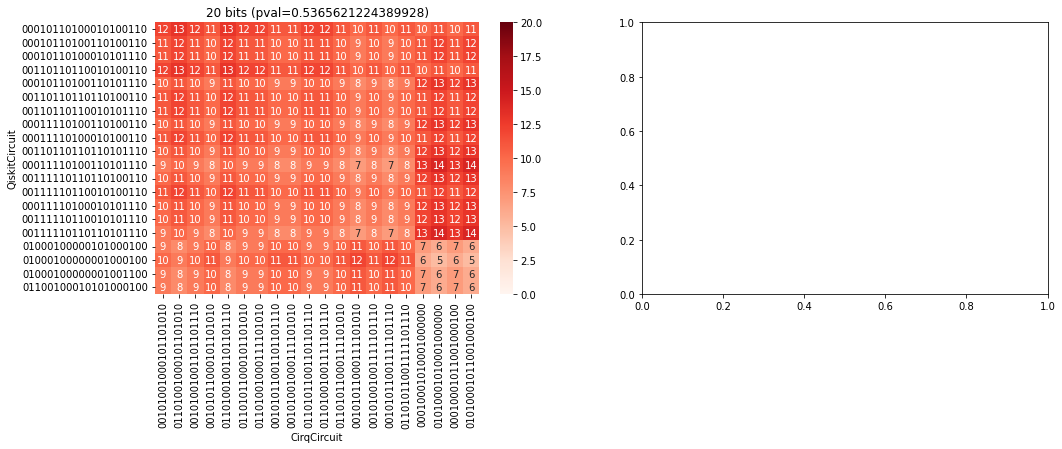

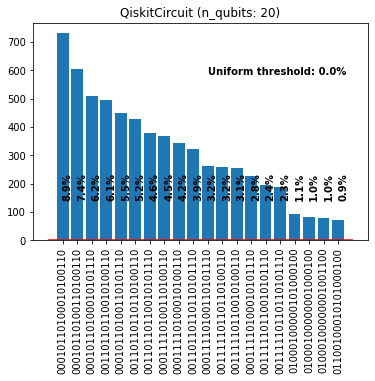

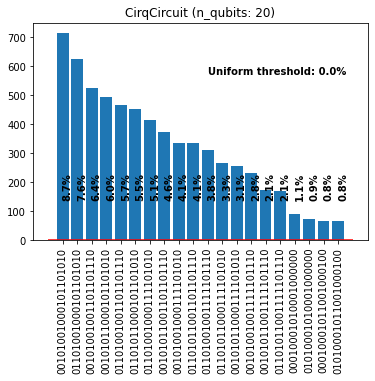

1it [00:02,  2.03s/it]


In [160]:
# plot the similarity between output strings (bitflip distance (aka XOR) or edit distance)

# select df to consider 
df = df_all

p_values = list(df["p_value"])
#all_codes = [f.replace(".json", "") for f in list(df["filename"])]
all_codes = ["1638906632_6713"]


TOP_K = 20
n_cols = 2
n_rows = math.ceil(len(all_codes) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5))
axes = axes.reshape(-1)

for ax, circuit_code, p_value in tqdm(zip(axes, all_codes, p_values)):
    inspect(code=circuit_code, p_value=p_value, folder=config["folder_execution_results"], top_k=TOP_K, ax=ax, verbose=True)
    plt.show()
    plot_execution_result(df=df_all, circuit_name=circuit_code+".json", platforms=["QiskitCircuit", "CirqCircuit"], top_k=TOP_K)